In [1]:
import os
import sys
from pathlib import  Path

import zipfile
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import  train_test_split

import tensorflow
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, Input, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives
from tensorflow.keras.metrics import TrueNegatives, Precision, Recall, AUC, binary_accuracy

from tensorflow.keras.optimizers import Adam, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1

from tensorboard.plugins.hparams import api as hp

from helper import *

In [2]:
import wandb
from wandb.keras import WandbCallback

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
d_set = tf.data.Dataset.range(10)
print(list(d_set.as_numpy_iterator()))

ll = len(list(d_set.as_numpy_iterator()))

tr_d_set = d_set.take(int(ll*0.6))
print(list(tr_d_set.as_numpy_iterator()))

val_d_set = d_set.skip(int(ll*0.6))
val_set = val_d_set.take(int(ll*0.2))
print(list(val_set.as_numpy_iterator()))

ts_d_set = val_d_set.skip(int(ll*0.2))
print(list(ts_d_set.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2


train_dataset, val_dataset = splits(
    ds_train, TRAIN_RATIO, VAL_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()),
#     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [6]:
print(list(train_dataset.take(1).as_numpy_iterator()),
    list(val_dataset.take(1).as_numpy_iterator()))

[(array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
    

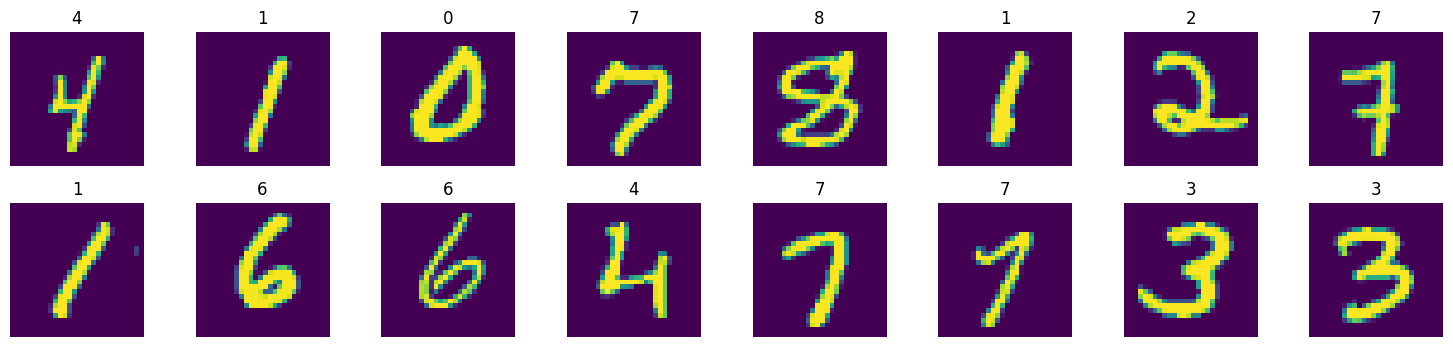

In [7]:
plt.figure(figsize=(15,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(image)
  plt.title(ds_info.features['label'].int2str(label.numpy()))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 24,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}


In [9]:
def resize_rescale(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [10]:
for image, label in train_dataset.take(1):
    print(image)

tf.Tensor(
[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  

In [11]:
train_ = train_dataset.map(resize_rescale)
train_data = train_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

val_ = val_dataset.map(resize_rescale)
validation_data = val_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

test_ = ds_test.map(resize_rescale)
# test_data = test_.shuffle(
#     buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

In [12]:
for image, label in train_data.take(1):
    print(image)

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience = 20,
    verbose=1,
    mode = 'auto',
    baseline= None,
    restore_best_weights = True
)

In [14]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(28,28,1)),
    
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (Batch  (None, 24, 24, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 16)          64        
 chNormalization)                                                
                                                        

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [16]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    verbose=2,
    callbacks=[early_stopping]
    )

Epoch 1/20



375/375 - 10s - loss: 0.8783 - sparse_categorical_accuracy: 0.7353 - val_loss: 0.5448 - val_sparse_categorical_accuracy: 0.8582 - 10s/epoch - 27ms/step
Epoch 2/20
375/375 - 8s - loss: 0.2822 - sparse_categorical_accuracy: 0.9245 - val_loss: 0.2165 - val_sparse_categorical_accuracy: 0.9390 - 8s/epoch - 21ms/step
Epoch 3/20
375/375 - 7s - loss: 0.1869 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.1601 - val_sparse_categorical_accuracy: 0.9557 - 7s/epoch - 20ms/step
Epoch 4/20
375/375 - 8s - loss: 0.1417 - sparse_categorical_accuracy: 0.9609 - val_loss: 0.1306 - val_sparse_categorical_accuracy: 0.9637 - 8s/epoch - 21ms/step
Epoch 5/20
375/375 - 8s - loss: 0.1151 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.1117 - val_sparse_categorical_accuracy: 0.9677 - 8s/epoch - 21ms/step
Epoch 6/20
375/375 - 7s - loss: 0.0963 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.0989 - val_sparse_categorical_accuracy: 0.9715 - 7s/epoch - 19ms/step
Epoch 7/20
375/375 - 7s - loss: 0.0823 - sp

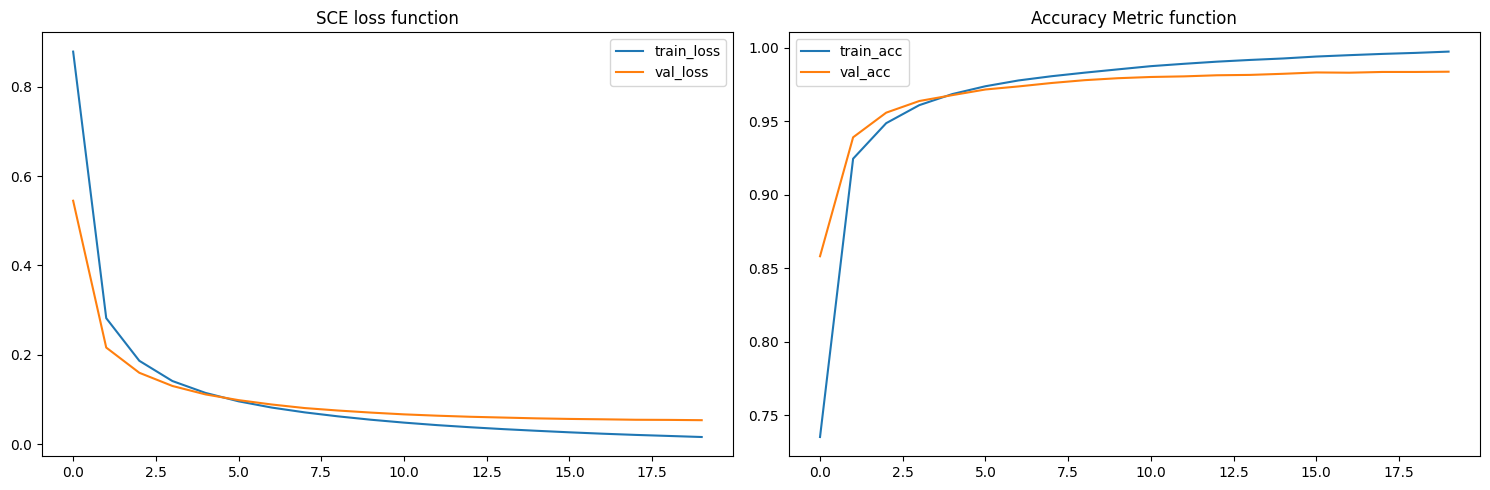

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['loss'], label="train_loss")
ax[0].plot(history.history['val_loss'], label="val_loss")
ax[0].set_title("SCE loss function")
ax[0].legend()

ax[1].plot(history.history['sparse_categorical_accuracy'], label="train_acc")
ax[1].plot(history.history['val_sparse_categorical_accuracy'], label="val_acc")
ax[1].set_title("Accuracy Metric function")
ax[1].legend()
plt.tight_layout()
plt.show()

In [18]:
test_data = test_.batch(1)

In [19]:
model.evaluate(test_data)

10000/10000 [==============================] - 33s 3ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9847


[0.048833560198545456, 0.9847000241279602]

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,precision_score,recall_score,roc_curve

In [21]:
y_pred = model.predict(test_data)

10000/10000 [==============================] - 26s 3ms/step


In [22]:
y_pred.shape

(10000, 10)

In [23]:
list(test_data.as_numpy_iterator())[0][1][0]

2

In [24]:
import numpy as np

label_list = []

for data_batch, label_batch in list(test_.as_numpy_iterator()):
    label_list.append(label_batch)

# test_labels = np.concatenate(label_list, axis=0)

In [25]:
len(label_list)

10000

In [26]:
test_labels=label_list.copy()

In [27]:
pred_labels = []
pred_probs = []
for probs in y_pred:
    pred_labels.append(np.argmax(probs))
    pred_probs.append(np.max(probs))

In [28]:
y_pred[0]

array([5.2783537e-07, 2.2850946e-07, 9.9997497e-01, 9.5180872e-07,
       3.6559234e-07, 4.8297090e-07, 8.1157856e-07, 2.2981101e-06,
       1.9221043e-05, 1.3874863e-07], dtype=float32)

In [29]:
print(pred_labels[0])
print(pred_probs[0])

2
0.99997497


1/1 [==============================] - 0s 30ms/step


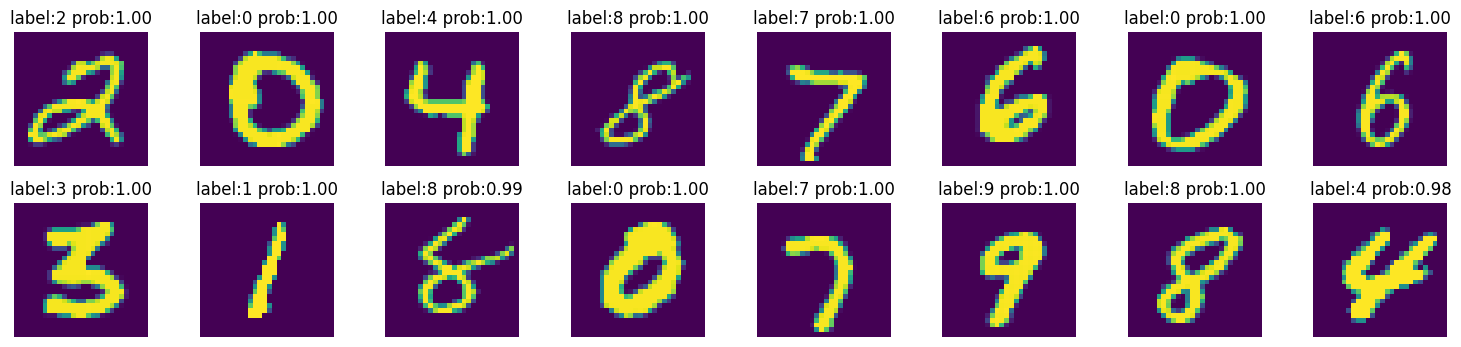

In [30]:
plt.figure(figsize=(15, 7))
for i, (image, label) in enumerate(test_data.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(tf.squeeze(image, axis=0))
  pred_prob_lst = model.predict(image)
  
  pred_label = np.argmax(pred_prob_lst)
  pred_prob = np.max(pred_prob_lst)
  
  plt.title(f"label:{pred_label} prob:{pred_prob:.2f}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
model.predict(test_data.take(1))

1/1 [==============================] - 0s 78ms/step


array([[5.2783537e-07, 2.2850946e-07, 9.9997497e-01, 9.5180872e-07,
        3.6559234e-07, 4.8297090e-07, 8.1157856e-07, 2.2981101e-06,
        1.9221043e-05, 1.3874863e-07]], dtype=float32)

## Saving Model

In [32]:
file_path = "./models/lenet"
model.save(file_path)

INFO:tensorflow:Assets written to: ./models/lenet\assets


INFO:tensorflow:Assets written to: ./models/lenet\assets


In [33]:
loaded_model = tf.keras.models.load_model(file_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (Batch  (None, 24, 24, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 16)          64        
 chNormalization)                                                
                                                        

In [34]:
file_path = "./models/lenet.hdf5"
model.save(file_path)

c:\Users\91981\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
loaded_model = tf.keras.models.load_model(file_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (Batch  (None, 24, 24, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 16)          64        
 chNormalization)                                                
                                                        